# lmax vs time

## lenmap2gclm

In [39]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.style
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.style.use('ggplot')
print(mpl.style.available)

epsilon = 1e-6
lmaxs = np.array([256*n-1 for n in np.arange(1,20)])
blacklist_CPU, blacklist_GPU = [], []

def flatten_extend(matrix):
    flat_list = []
    
    for row in matrix:
        flat_list.extend(row)
    return flat_list

runinfos = [
    ('CPU', 'lenspyx'),
    # ('CPU', 'duccnufft'),
    ('GPU', 'cufinufft')    
    ]

blacklist_runinfos = []

popstr_runinfos_CPU = [
    ["setup"],
    # ["adjointsynthesisgeneral"],
    ["lenmap2gclm()"],
    ["Transfers ->", "Transfer <-"],
    ["dlm2pointing", "spin-1 synth", "pointing"],
    ["dlm2pointing - allocation", "dlm2pointing - dlm scaling", "pointing"],
    ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    ["rotation", "rotate"]
]

popstr_runinfos_GPU = [
    ["setup"],
    ["adjointsynthesisgeneral"],
    ["lenmap2gclm()"],
    ["nuFFT init", "FFTshift"],
    ["Transfers ->", "Transfer <-"],
    ["dlm2pointing", "spin-1 synth", "pointing"],
    ["dlm2pointing - allocation", "dlm2pointing - dlm scaling", "pointing"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    ["rotation", "rotate"]
]
popstrCPU = flatten_extend(popstr_runinfos_CPU)
popstrGPU = flatten_extend(popstr_runinfos_GPU)

## Check which files exist
fns = '/mnt/home/sbelkner/git/cunushtht/test/benchmark/timings/lenmap2gclm/{backend}_{solver}_{lmax}_e{epsilon}'
for runinfoi, runinfo in enumerate(runinfos):
    _ = []
    for lmax in lmaxs:
        fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon)
        if not os.path.isfile(fn):
            _.append(lmax)
    blacklist_runinfos.append(_)


data = []
for runinfoi, runinfo in enumerate(runinfos):
    _ = []
    for lmax in lmaxs:
        if lmax not in blacklist_runinfos[runinfoi]:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon)
            with open(fn, "r") as file:
                _.append(json.load(file))
    data.append(_)

for runinfoi, runinfo in enumerate(runinfos):
    if runinfo[0] == 'CPU':
        popstr = popstrCPU
    else:
        popstr = popstrGPU
    for popstring in popstr:
        for d in data[runinfoi]:
            if popstring in d:
                d.pop(popstring)
              
ress = []
keys = []
for runinfoi, runinfo in enumerate(runinfos):
    data_across_l = {}
    for d in data[runinfoi]:
        keys = d.keys()
        for keyi, key in enumerate(keys):
            if key in data_across_l:
                data_across_l[key].append(d[key])
            else:
                data_across_l[key] = [d[key]]
    _ = np.array([v for k, v in data_across_l.items()])
    ress.append(_)
    
lmax_ress = []
for blacklist_runinfoi, blacklist_runinfo in enumerate(blacklist_runinfos):
    lmax_ress.append(np.array([l for l in lmaxs if l not in blacklist_runinfo]))
print(lmax_ress[1])

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
[]


### DUCCnuFFT

[] 0


IndexError: list index out of range

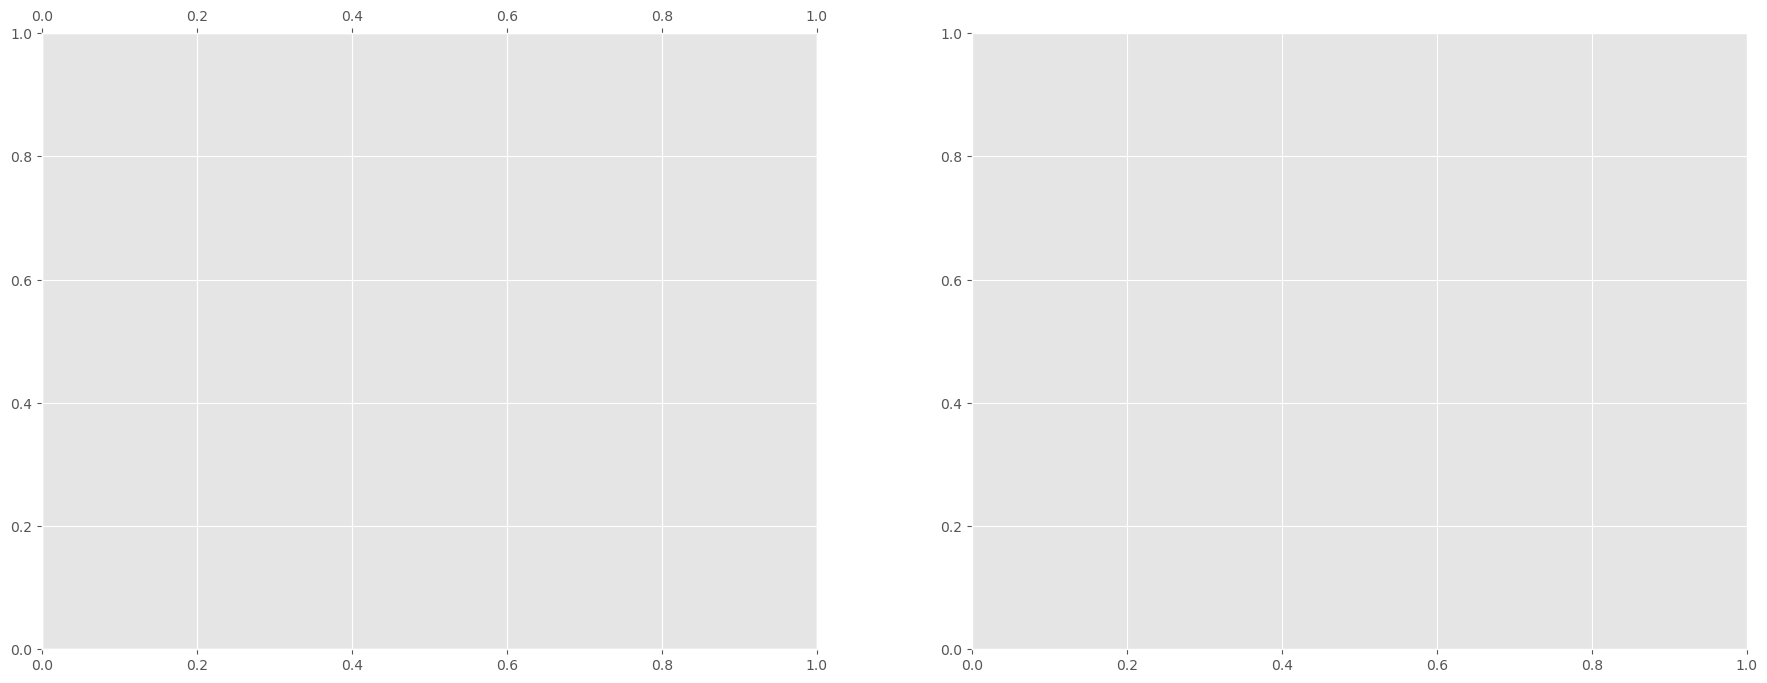

In [40]:
compis = [0,1]

fig, ax = plt.subplots(1,len(runinfos), figsize=(22,8), sharey=False)
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))
print(lmax_intersecs, len(lmax_intersecs))

axt = ax[0].twiny()
bottom = np.zeros(shape=(len(lmax_intersecs)))
for rowi, row in enumerate(ress[1]): #[:-1,:]
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    axt.barh(lmax_intersecs.astype(str), -row[mask21], 1, align='center', left=bottom, label=list(keys)[rowi])
    bottom -= row
    axt.set_xlim(-0.5, 0.5)
    
bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, row in enumerate(ress[0]): #[:-1,:]
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    ax[0].barh(lmax_intersecs.astype(str), row[mask12], 1, align='center', left=bottom)
    bottom += row[mask12]
    ax[0].set_xlim(-5, 5)
    
    
ax[0].text(0.75, 0.5, 'CPU', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=20)
ax[0].text(0.25, 0.5, 'GPU', horizontalalignment='center', verticalalignment='center', transform=axt.transAxes, fontsize=20)
        
axt.legend(ncol=4)
axt.vlines(0,0,len(lmax_intersecs), color='black', lw=2)
axt.set_title("{} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[0].set_xlabel('Time [s]')
axt.set_ylabel(r'Multipole $\ell$')
axt.set_xticks([])
ax[0].set_xticklabels([-0.5,-0.4,-0.2,0.,2,4])

width = np.diff(lmax_ress[compis[0]])[0]//3

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        ress[compis[0]], ress[compis[1]])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = -width + rowi/len(keys)*2*width
    ax[1].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 3*width/len(keys), align='center', label=list(keys)[rowi])
    # bottom += row1[mask12]/row2[mask21]
ax[1].legend()
ax[1].set_xlim(0,15)
ax[1].set_yticks(lmax_intersecs)
ax[1].set_yticklabels(lmax_intersecs)
# ax[1].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
ax[1].set_xlabel('Speed up')
ax[1].set_ylabel(r'Multipole $\ell$')

# ax[resi].set_ylim(0.0, 1.5)
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

[ 255  511  767 1023 1279 1535 1791 2047 2303 2559 3071] 11


/tmp/ipykernel_766767/1029696905.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([-0.5,-0.4,-0.2,0.,2,4])


Text(0, 0.5, 'Multipole $\\ell$')

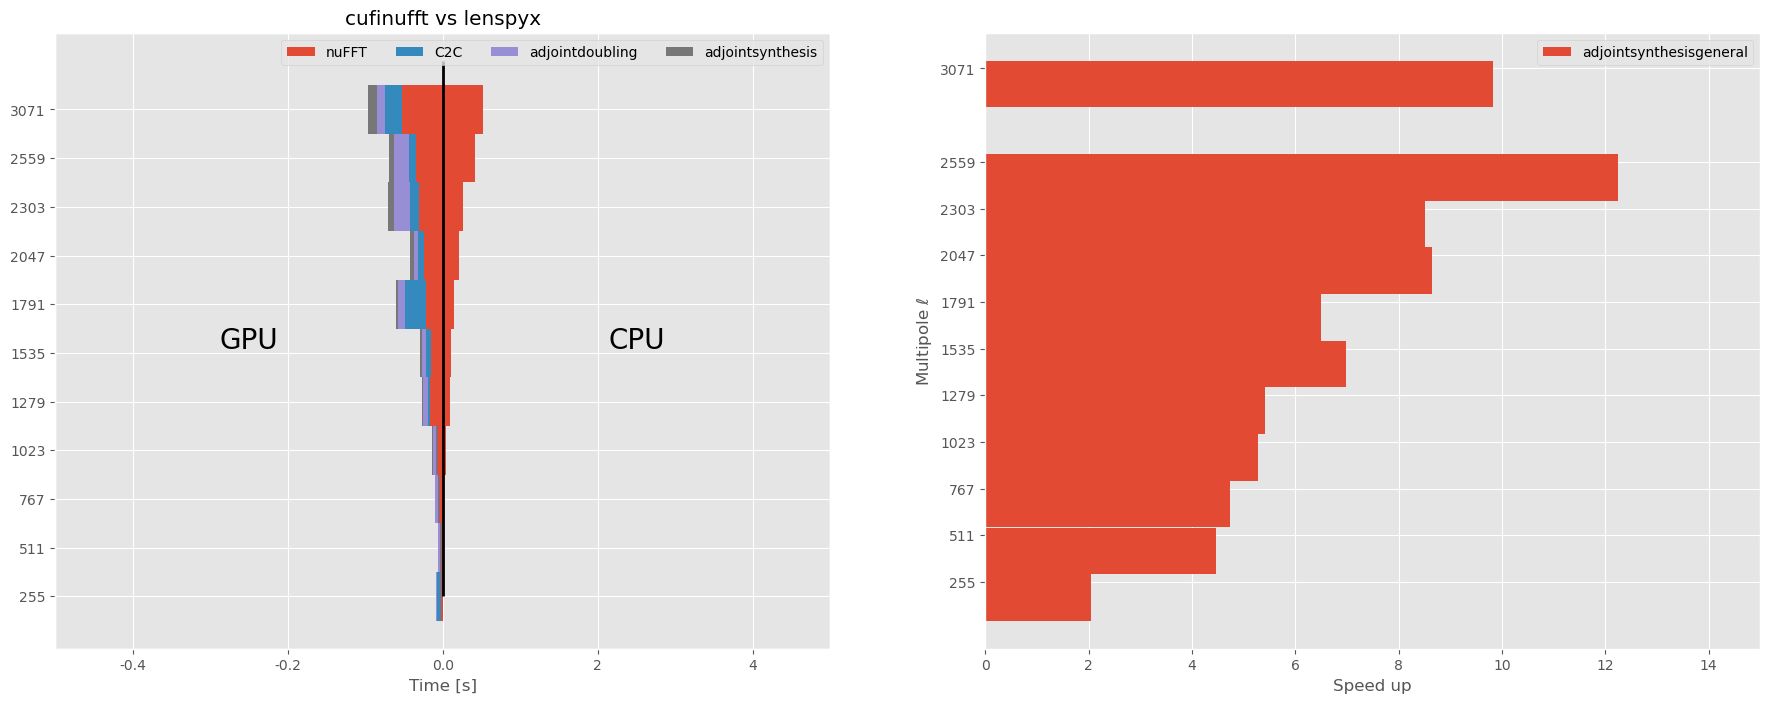

In [20]:
fig, ax = plt.subplots(1,len(runinfos), figsize=(22,8), sharey=False)
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))
print(lmax_intersecs, len(lmax_intersecs))

axt = ax[0].twiny()
bottom = np.zeros(shape=(len(lmax_intersecs)))
for rowi, row in enumerate(ress[1]): #[:-1,:]
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    axt.barh(lmax_intersecs.astype(str), -row[mask21], 1, align='center', left=bottom, label=list(keys)[rowi])
    bottom -= row
    axt.set_xlim(-0.5, 0.5)
    
bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, row in enumerate(ress[0]): #[:-1,:]
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    ax[0].barh(lmax_intersecs.astype(str), row[mask12], 1, align='center', left=bottom)
    bottom += row[mask12]
    ax[0].set_xlim(-5, 5)
    
    
ax[0].text(0.75, 0.5, 'CPU', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=20)
ax[0].text(0.25, 0.5, 'GPU', horizontalalignment='center', verticalalignment='center', transform=axt.transAxes, fontsize=20)
        
axt.legend(ncol=4)
axt.vlines(0,0,len(lmax_intersecs), color='black', lw=2)
axt.set_title("{} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[0].set_xlabel('Time [s]')
axt.set_ylabel(r'Multipole $\ell$')
axt.set_xticks([])
ax[0].set_xticklabels([-0.5,-0.4,-0.2,0.,2,4])

compis = [0,1]
width = np.diff(lmax_ress[compis[0]])[0]//3

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        ress[compis[0]], ress[compis[1]])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = -width + rowi/len(keys)*2*width
    ax[1].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 3*width/len(keys), align='center', label=list(keys)[rowi])
    # bottom += row1[mask12]/row2[mask21]
ax[1].legend()
ax[1].set_xlim(0,15)
ax[1].set_yticks(lmax_intersecs)
ax[1].set_yticklabels(lmax_intersecs)
# ax[1].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
ax[1].set_xlabel('Speed up')
ax[1].set_ylabel(r'Multipole $\ell$')

# ax[resi].set_ylim(0.0, 1.5)
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

0 6 [0.02364983 0.29595106 0.33928846 0.53515238 0.71272839 0.86286702
 1.05147837 1.31363538 1.36432879 1.63683292 1.21200406 1.84677834
 1.74662012 2.53491249 2.08558078]
1 6 [ 25.41769042  65.56492411  93.76024412  89.60632447 115.67752741
 121.85986635 132.40674379 111.52334235 132.89599941 142.02753575
 115.49875825 146.10441984 141.88127806 148.52852178 126.35865876]
2 6 [  3.29771599  17.78482199  25.66817496  34.56778978  40.14349096
  55.60185094  66.21498911  78.45133801  79.69469906  87.8521759
  76.7494577   92.3056993   78.13125988 101.62671664  72.85515717]
3 6 [0.09163714 1.60820234 2.05565614 1.88876115 3.62099954 4.2603112
 2.7106534  4.99173215 2.32689144 2.76367811 2.38251922 2.34940702
 2.43038621 2.28903203 1.91453875]
4 6 [2.10387911 2.01384428 2.65701814 3.01742515 2.53255052 2.31274878
 2.39664261 2.42884228 2.60967735 2.78559858 2.55330821 2.73486494
 3.42327821 1.33932597 1.31014548]


/tmp/ipykernel_2353139/3737310064.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
/tmp/ipykernel_2353139/3737310064.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')


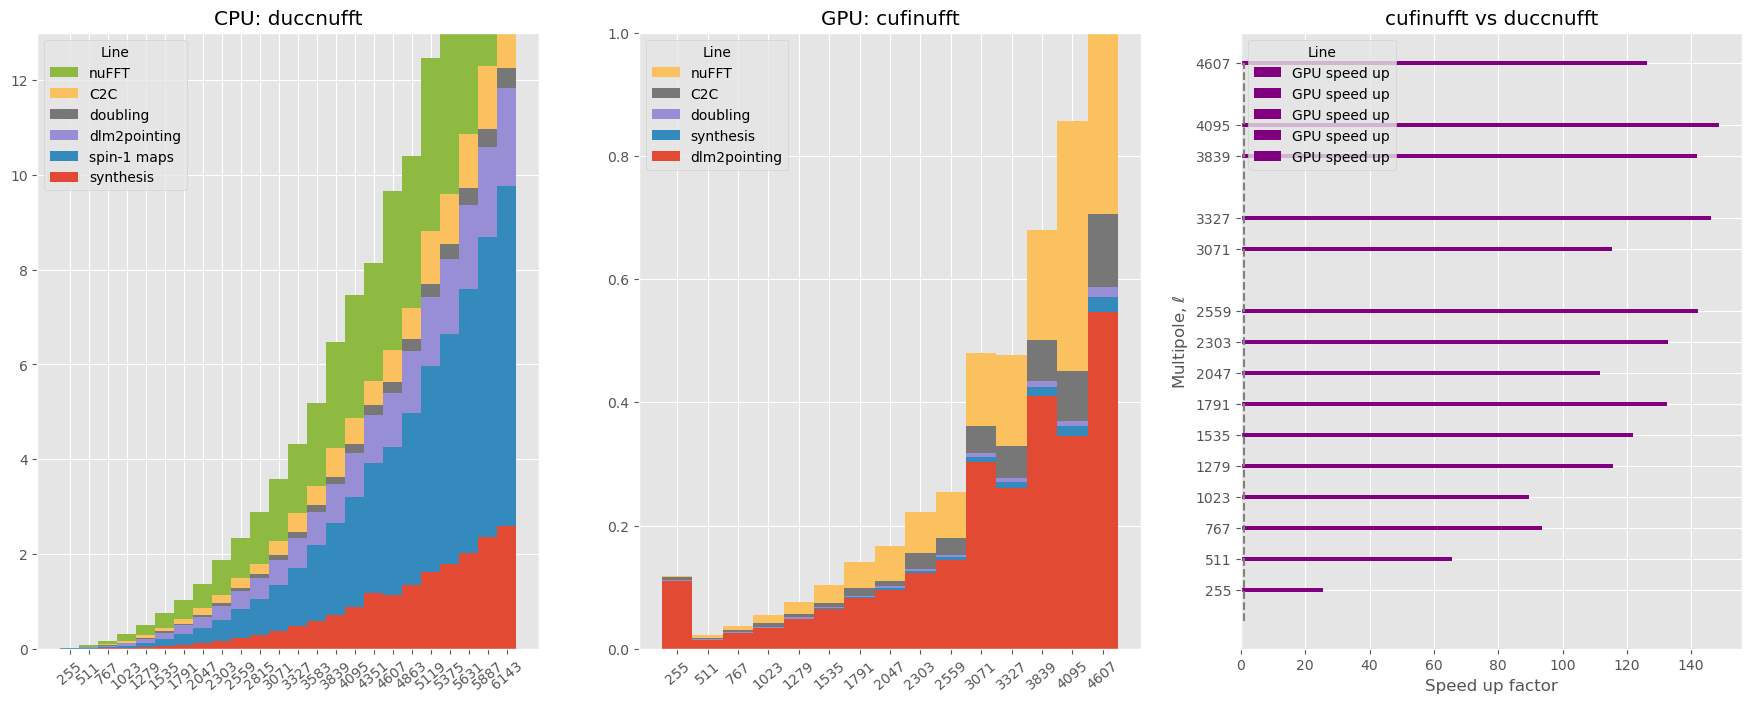

In [30]:
# For comparison with lenspyx, must sum over all rows
fig, ax = plt.subplots(1,len(runinfos)+1,figsize=(22,8), sharey=False)
for resi, res in enumerate(ress):
    bottom = np.zeros(shape=(len(lmax_ress[resi])))
    keys = data[resi][0].keys()
    for rowi, row in enumerate(res): #[:-1,:]
        # if rowi == 0:
            # ax[0].bar(lmaxs.astype(str), [0,0], 1, align='center', bottom=bottom, label='_')
        ax[resi].bar(lmax_ress[resi].astype(str), row, 1, align='center', bottom=bottom, label=list(keys)[rowi])
        bottom += row
    ax[resi].legend()
    ax[resi].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
    
    handles, labels = ax[resi].get_legend_handles_labels()
    ax[resi].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
ax[0].set_ylim(0.0, 13.0)
ax[1].set_ylim(0.0, 1.0)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')

compis = [0,1]
lmax_unions = []
width = np.diff(lmax_ress[compis[0]])[0]//4
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        ress[compis[0]], ress[compis[1]])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = -width + rowi/len(keys)*2*width
    offset = 0
    print(rowi, len(keys), row1[mask12]/row2[mask21])
    ax[2].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 3*width/len(keys), align='center', label="GPU speed up", color='purple')
    # bottom += row1[mask12]/row2[mask21]
ax[2].vlines(1,0,np.max(lmax_intersecs), color='grey', ls='--')
ax[2].legend()
ax[2].set_ylabel(r"Multipole, $\ell$")
ax[2].set_xlabel("Speed up factor")
ax[2].set_title("{} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[2].set_yticks(lmax_intersecs)
ax[2].set_yticklabels(lmax_intersecs)
# ax[resi].set_ylim(0.0, 1.5)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

### Lenspyx

IndexError: list index out of range

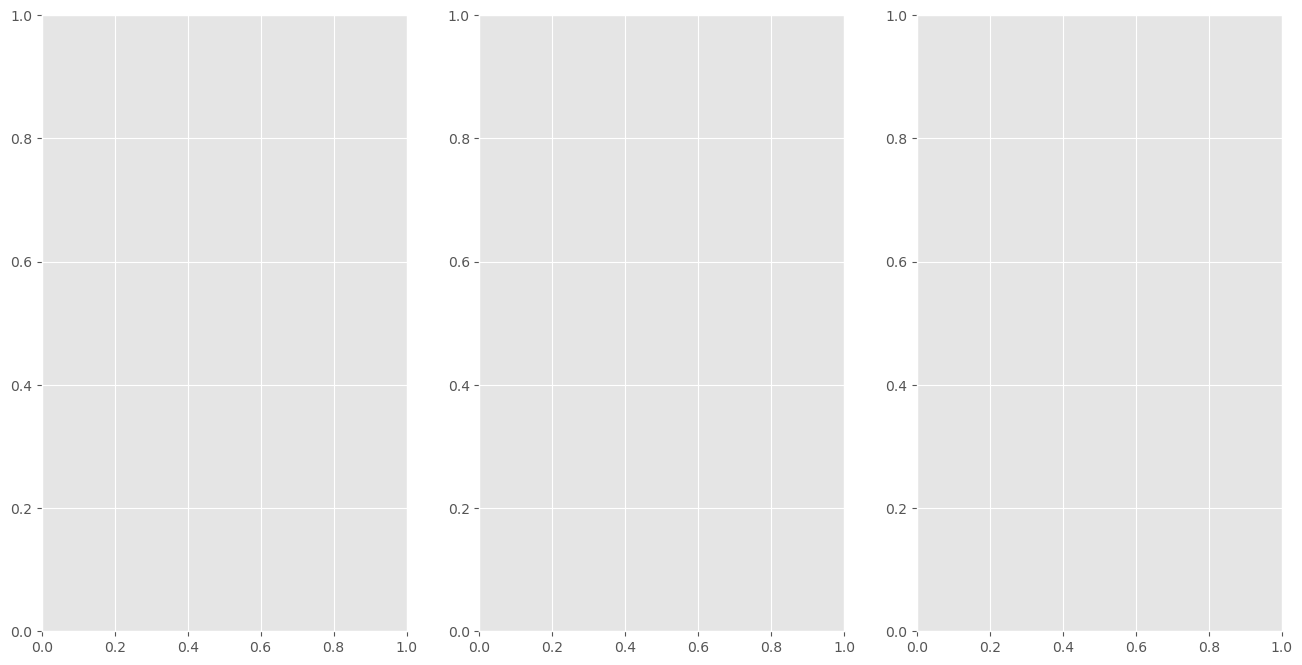

In [3]:
# For comparison with lenspyx, must sum over all rows
fig, ax = plt.subplots(1,len(runinfos)+1,figsize=(16,8), sharey=False)
for resi, res in enumerate(ress):
    bottom = np.zeros(shape=(len(lmax_ress[resi])))
    keys = data[resi][0].keys()
    for rowi, row in enumerate(res): #[:-1,:]
        # if rowi == 0:
            # ax[0].bar(lmaxs.astype(str), [0,0], 1, align='center', bottom=bottom, label='_')
        ax[resi].bar(lmax_ress[resi].astype(str), row, 1, align='center', bottom=bottom, label=list(keys)[rowi])
        bottom += row
    ax[resi].legend()
    ax[resi].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
    
    handles, labels = ax[resi].get_legend_handles_labels()
    ax[resi].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
ax[0].set_ylim(0.0, 2.0)
ax[1].set_ylim(0.0, .35)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')

compis = [0,1]
lmax_unions = []
width = np.diff(lmax_ress[compis[0]])[0]//4
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        [np.sum(ress[compis[0]],axis=0)], [np.sum(ress[compis[1]],axis=0)])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = -width + rowi/len(keys)*2*width
    offset = 0
    print(rowi, len(keys), row1[mask12]/row2[mask21])
    ax[2].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 200, align='center', label="speed up", color='purple')
    # bottom += row1[mask12]/row2[mask21]
ax[2].vlines(1,0,np.max(lmax_intersecs), color='grey', ls='--')
ax[2].legend()
ax[2].set_ylabel(r"Multipole, $\ell$")
ax[2].set_xlabel("Speed up factor")
ax[2].set_title("lenmap2gclm(): {} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[2].set_yticks(lmax_intersecs)
ax[2].set_yticklabels(lmax_intersecs)
# ax[resi].set_ylim(0.0, 1.5)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

[] 0


IndexError: list index out of range

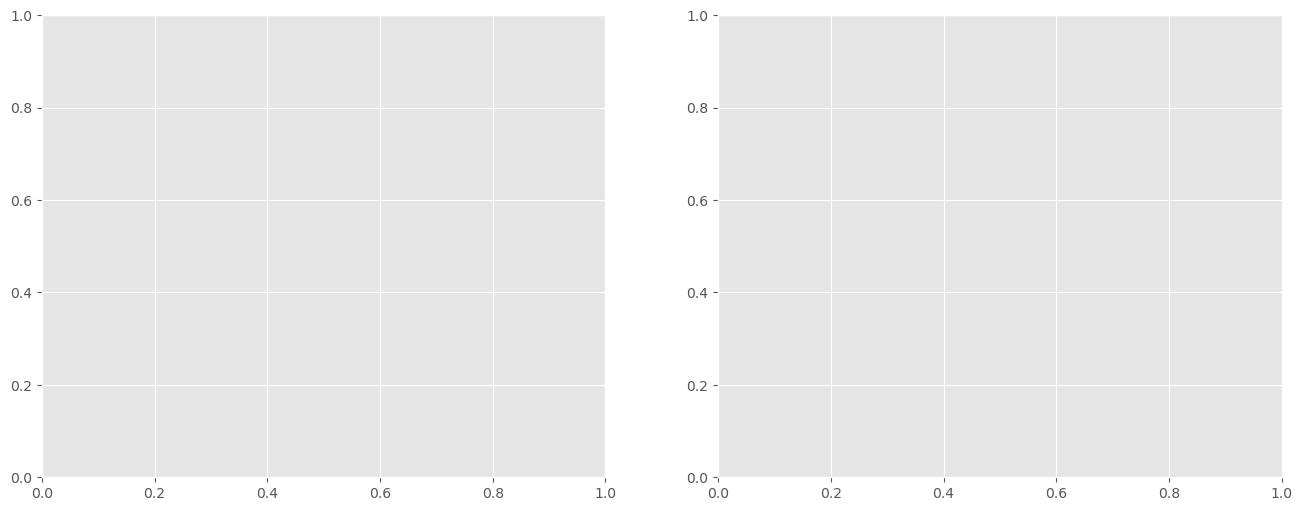

In [4]:
fig, ax = plt.subplots(1,len(runinfos), figsize=(16,6), sharey=False)
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))
print(lmax_intersecs, len(lmax_intersecs))
gpu_xlim = 0.5
cpu_xlim = 1.0

keys = data[1][0].keys()
axt = ax[0].twiny()
bottom = np.zeros(shape=(len(lmax_intersecs)))
for rowi, row in enumerate(ress[1]): #[:-1,:]
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    axt.barh(lmax_intersecs.astype(str), -row[mask21], 1, align='center', left=bottom, label=list(keys)[rowi], edgecolor='black')
    bottom -= row
    axt.set_xlim(-gpu_xlim, gpu_xlim)

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
colors = [None, 'darkgrey']
for rowi, row in enumerate(ress[0]):
    ax[0].bar([0,0], [0,0], 1, align='center', bottom=[0,0], label='_')
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mod = '_' if rowi == 0 else ""
    ax[0].barh(lmax_intersecs.astype(str), row[mask12], 1, align='center', left=bottom, label=mod+list(keys)[rowi], color='green', edgecolor='black')
    bottom += row[mask12]
    ax[0].set_xlim(-cpu_xlim, cpu_xlim)

ax[0].text(0.75, 0.5, 'CPU', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=20)
ax[0].text(0.25, 0.5, 'GPU', horizontalalignment='center', verticalalignment='center', transform=axt.transAxes, fontsize=20)
        
axt.legend(ncol=2, loc='lower right')
axt.vlines(0,0,len(lmax_intersecs[:-1]), color='black', lw=2)
axt.set_title("adjoint synthesis general: {} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[0].set_xlabel('Time [s]')
axt.set_ylabel(r'Multipole $\ell$')
axt.set_xticks([])
# ax[0].set_xticks([float("{:.2f}".format(n)) for n in [-gpu_xlim,-gpu_xlim/4*3,-gpu_xlim/4*2,-gpu_xlim/4.,0, cpu_xlim,cpu_xlim/4*3,cpu_xlim/4*2,cpu_xlim/4.]])
ax[0].set_xticklabels(["{:.3f}".format(n) for n in [-gpu_xlim,-gpu_xlim/4*3,-gpu_xlim/4*2,-gpu_xlim/4*1, 0, 0.25,0.5,0.75,1.0]])

compis = [0,1]
width = np.diff(lmax_ress[compis[0]])[0]//1

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[1][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        [np.sum(ress[compis[0]],axis=0)], [np.sum(ress[compis[1]],axis=0)])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = -width + rowi/len(keys)*2*width
    offset = 0
    print(row1[mask12], row2)
    ax[1].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 200, align='center', label="adjoint synthesis general", color='darkgrey', edgecolor='black')
    # bottom += row1[mask12]/row2[mask21]
ax[1].legend()
ax[1].set_yticks(lmax_intersecs)
ax[1].set_yticklabels(lmax_intersecs)
ax[1].set_xlim(0,5)
# ax[1].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
ax[1].set_xlabel('Speed up')
ax[0].set_ylabel(r'Multipole $\ell$')

# ax[resi].set_ylim(0.0, 1.5)
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

## gclm2lenmap

In [38]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.style
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.style.use('ggplot')
print(mpl.style.available)

import cunusht

epsilon = 1e-4
lmaxs = np.array([256*n-1 for n in np.arange(1,20)])
blacklist_CPU, blacklist_GPU = [], []

def lmax2npoints(lmax):
    return 2*lmax**2

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

runinfos = [
    ('CPU', 'lenspyx'),
    # ('CPU', 'duccnufft'),
    ('GPU', 'cufinufft')
    ]

blacklist_runinfos = []


popstr_runinfos_CPU = [
    ["CPU_Lenspyx_transformer"],
    ["init"],
    ["gclm2lenmap"],
    ["synthesisgeneral"],
    ["setup"],
    ["plane", "SphereInterpol setup", "borders"],
    ["dlm2pointing", "dlm2pointing - allocation", "dlm2pointing - dlm scaling"],
    ["pointing"],
    ["spin-1 synth"],
    # ["nuFFT2d2", "C2C", "synthesis"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    ["rotation", "rotate"],
    ["Transfers ->", "Transfer <-"],
]

popstr_runinfos_GPU = [
    ["GPU_cufinufft_transformer"],
    ["init - setup", "init - deflectionlib", "init - SHTlib", "init - allocation", "init - weights", "nuFFT and C2C - plan", "init"],
    ["gclm2lenmap"],
    ["synthesisgeneral"],
    ["setup"],
    ["nuFFT - init", "nuFFT - plan"],
    # ['nuFFT - exec', 'nuFFT - set points']
    ["dlm2pointing"],
    ["pointing"],
    ["spin-1 synth"],
    ["ascontiguousarray"],
    # ["nuFFT2d2", "C2C", "synthesis"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    # ["doubling"],
    ["rotation", "rotate"],
    ["Transfers ->", "Transfer <-"],
]

planned = "planned"
popstrCPU = flatten_extend(popstr_runinfos_CPU)
popstrGPU = flatten_extend(popstr_runinfos_GPU)

## Check which files exist

dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
for runinfoi, runinfo in enumerate(runinfos):
    if runinfo[0] == 'CPU':
        fns = dirnames.format("CPU_Lenspyx_transformer", "gclm2lenmap") + "lmax{lmax}_epsilon{epsilon}"
    else:
        fns = dirnames.format("GPU_cufinufft_transformer", "gclm2lenmap") + "lmax{lmax}_epsilon{epsilon}"
    _ = []
    for lmax in lmaxs:
        fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned)
        if not os.path.isfile(fn):
            print(f"couldnt find {fn}")
            _.append(lmax)
    blacklist_runinfos.append(_)


data = []
for runinfoi, runinfo in enumerate(runinfos):
    if runinfo[0] == 'CPU':
        fns = dirnames.format("CPU_Lenspyx_transformer", "gclm2lenmap") + "lmax{lmax}_epsilon{epsilon}"
    else:
        fns = dirnames.format("GPU_cufinufft_transformer", "gclm2lenmap") + "lmax{lmax}_epsilon{epsilon}"
    _ = []
    for lmax in lmaxs:
        if lmax not in blacklist_runinfos[runinfoi]:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned)
            with open(fn, "r") as file:
                _.append(json.load(file))
        else:
            print(f"not appending {lmax} to {runinfo}")
    data.append(_)

for runinfoi, runinfo in enumerate(runinfos):
    if runinfo[0] == 'CPU':
        popstr = popstrCPU
    else:
        popstr = popstrGPU
    for popstring in popstr:
        for d in data[runinfoi]:
            if popstring in d:
                d.pop(popstring)
# print('---')
              
ress = []
keys = []
for runinfoi, runinfo in enumerate(runinfos):
    data_across_l = {}
    for d in data[runinfoi]:
        keys = d.keys()
        for keyi, key in enumerate(keys):
            if key in data_across_l:
                data_across_l[key].append(d[key])
            else:
                data_across_l[key] = [d[key]]
    _ = np.array([v for k, v in data_across_l.items()])
    ress.append(_)
    
lmax_ress = []
for blacklist_runinfoi, blacklist_runinfo in enumerate(blacklist_runinfos):
    lmax_ress.append(np.array([l for l in lmaxs if l not in blacklist_runinfo]))
print(lmax_ress[1])

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
[ 255  511  767 1023 1279 1535 1791 2047 2303 2559 2815 3071 3327 3583
 3839 4095 4351 4607 4863]


In [39]:
print([len(r) for r in ress[0]], [len(r) for r in ress[1]])
""" if numbers are different, then CPU (0) or GPU (1) have different number of timings for the same key, across lmax"""

[19, 19, 19, 19] [19, 19, 19, 19]


' if numbers are different, then CPU (0) or GPU (1) have different number of timings for the same key, across lmax'

/tmp/ipykernel_2124583/3575544538.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
/tmp/ipykernel_2124583/3575544538.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')


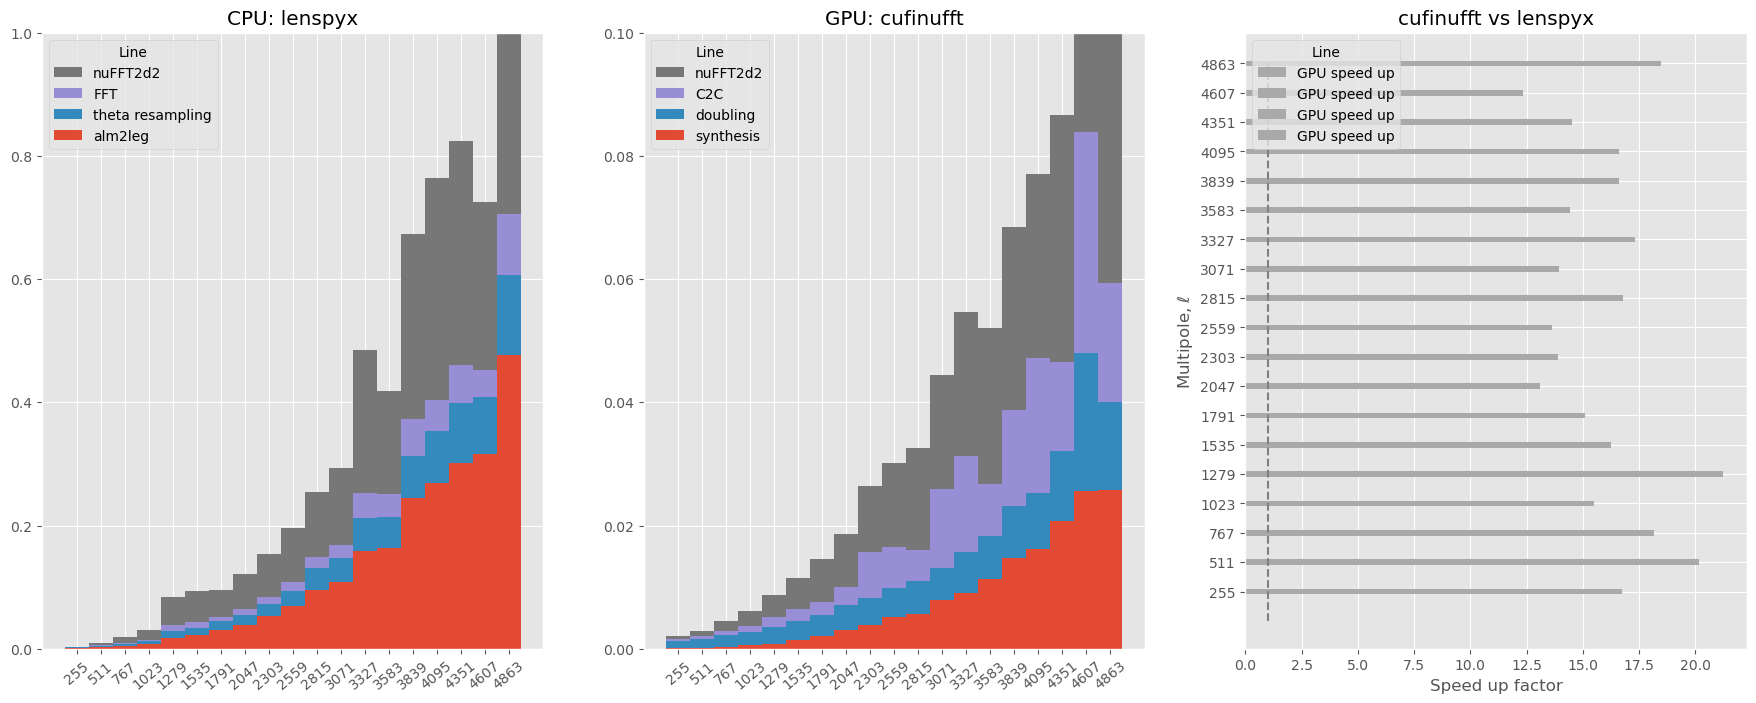

In [40]:
# For comparison with lenspyx, must sum over all rows
fig, ax = plt.subplots(1,len(runinfos)+1,figsize=(22,8), sharey=False)
for resi, res in enumerate(ress):
    bottom = np.zeros(shape=(len(lmax_ress[resi])))
    keys = data[resi][0].keys()
    for rowi, row in enumerate(res): #[:-1,:]
        # if rowi == 0:
            # ax[0].bar(lmaxs.astype(str), [0,0], 1, align='center', bottom=bottom, label='_')
        ax[resi].bar(lmax_ress[resi].astype(str), row, 1, align='center', bottom=bottom, label=list(keys)[rowi])
        bottom += row
    ax[resi].legend()
    ax[resi].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
    
    handles, labels = ax[resi].get_legend_handles_labels()
    ax[resi].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
ax[0].set_ylim(0.0, 1.0)
ax[1].set_ylim(0.0, .1)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')

compis = [0,1]
lmax_unions = []
width = np.diff(lmax_ress[compis[0]])[0]//4
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        ress[compis[0]], ress[compis[1]])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = -width + rowi/len(keys)*2*width
    offset = 0
    ax[2].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 3*width/len(keys), align='center', label="GPU speed up", color='darkgrey')
    # bottom += row1[mask12]/row2[mask21]
ax[2].vlines(1,0,np.max(lmax_intersecs), color='grey', ls='--')
ax[2].legend()
ax[2].set_ylabel(r"Multipole, $\ell$")
ax[2].set_xlabel("Speed up factor")
ax[2].set_title("{} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[2].set_yticks(lmax_intersecs)
ax[2].set_yticklabels(lmax_intersecs)
# ax[resi].set_ylim(0.0, 1.5)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

[ 255  511  767 1023 1279 1535 1791 2047 2303 2559 2815 3071 3327 3583
 3839 4095 4351 4607 4863] 19


/tmp/ipykernel_2124583/4209280437.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(["{:.3f}".format(n) for n in [gpu_xlim,gpu_xlim/4*3,gpu_xlim/4*2,gpu_xlim/4*1, 0, cpu_xlim/4, cpu_xlim/4*2, cpu_xlim/4*3, cpu_xlim]])
/tmp/ipykernel_2124583/4209280437.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axt.set_yticklabels(["{:3.2e}".format(l) for l in lmax2npoints(lmax_intersecs)])


Text(0.25, 0.5, 'GPU')

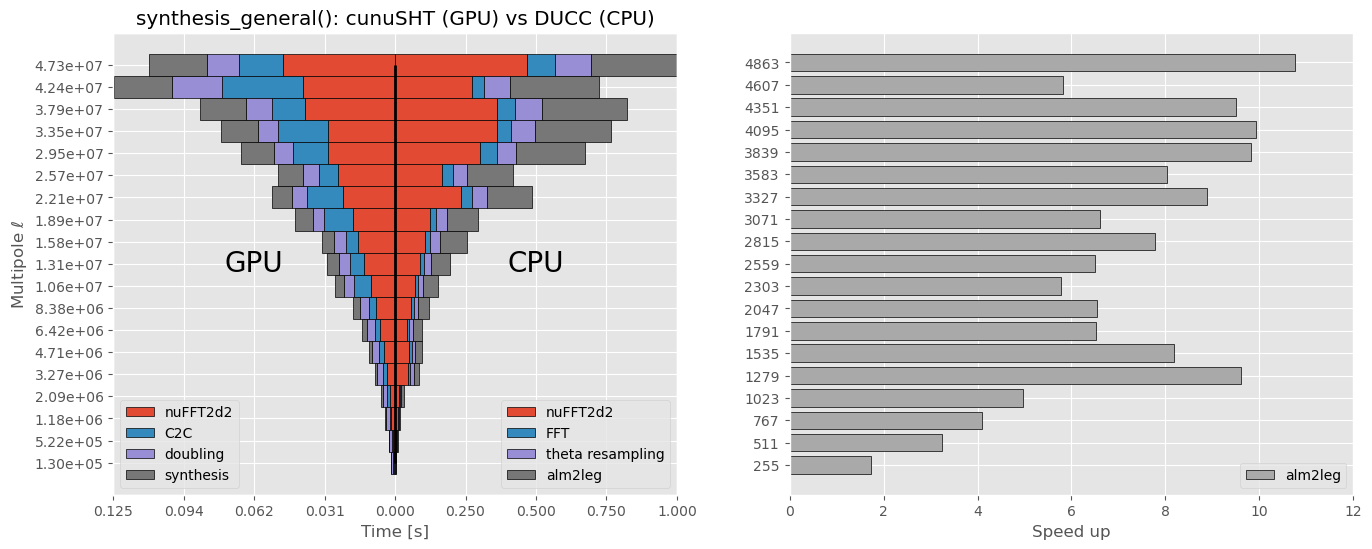

In [41]:
compis = [0,1]
fig, ax = plt.subplots(1,len(runinfos), figsize=(16,6), sharey=False)
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))
print(lmax_intersecs, len(lmax_intersecs))

gpu_xlim = 0.125
cpu_xlim = 1
ax[0].set_xticklabels(["{:.3f}".format(n) for n in [gpu_xlim,gpu_xlim/4*3,gpu_xlim/4*2,gpu_xlim/4*1, 0, cpu_xlim/4, cpu_xlim/4*2, cpu_xlim/4*3, cpu_xlim]])

axt = ax[0].twiny()
keys = list(data[1][0].keys())[::-1]
bottom = np.zeros(shape=(len(lmax_intersecs)))
for rowi, row in enumerate(ress[1][::-1]): #[:-1,:]
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    axt.barh(lmax_intersecs.astype(str), -row[mask21], 1, align='center', left=bottom, label=list(keys)[rowi], edgecolor='black')
    bottom -= row
    axt.set_xlim(-gpu_xlim, gpu_xlim)
    
axt.legend(ncol=1, loc='lower left')
    
bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, row in enumerate(ress[0][::-1]): #[:-1,:]
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    ax[0].barh(lmax_intersecs.astype(str), row[mask12], 1, align='center', left=bottom, label=list(keys)[::-1][rowi], edgecolor='black')#, color='green')
    bottom += row[mask12]
    ax[0].set_xlim(-cpu_xlim, cpu_xlim)
    
# axt.set_yticks(lmax2npoints(lmax_intersecs))
axt.set_yticklabels(["{:3.2e}".format(l) for l in lmax2npoints(lmax_intersecs)])
        
ax[0].legend(ncol=1, loc='lower right')
axt.vlines(0,0,len(lmax_intersecs[:-1]), color='black', lw=2)
axt.set_title("synthesis_general(): cunuSHT (GPU) vs DUCC (CPU)")
ax[0].set_xlabel('Time [s]')
axt.set_ylabel(r'Multipole $\ell$')
axt.set_xticks([])


width = np.diff(lmax_ress[compis[0]])[0]//3

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        [np.sum(ress[compis[0]],axis=0)], [np.sum(ress[compis[1]],axis=0)])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = 0 #-width + rowi/len(keys)*2*width
    ax[1].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 200, align='center', label=list(keys)[rowi], edgecolor='black', color='darkgrey')
    # bottom += row1[mask12]/row2[mask21]
ax[1].legend()


ax[1].set_yticks(lmax_intersecs)
ax[1].set_yticklabels(["{:d}".format(l) for l in lmax_intersecs])
# ax[1].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
ax[1].set_xlabel('Speed up')
ax[0].set_ylabel(r'Multipole $\ell$')


ax[1].set_xlim(0, 12) # 30

ax[0].text(0.75, 0.5, 'CPU', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=20)
ax[0].text(0.25, 0.5, 'GPU'.format(":\nplanned"), horizontalalignment='center', verticalalignment='center', transform=axt.transAxes, fontsize=20)

# ax[resi].set_ylim(0.0, 1.5)
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

In [ ]:
tot_Gbyte = (5e7+2*5e7+1e8+2*1e4*1e4)*8/1e9
tot_Gbyte

0.000000001702128

1.702128e-09

In [1]:
from jax import grad
import jax.numpy as jnp
def f(x):
    return x**2.

gradf = grad(f)
gradf(jnp.array(3.))

: 

### Lenspyx

/tmp/ipykernel_993665/750189834.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
/tmp/ipykernel_993665/750189834.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')


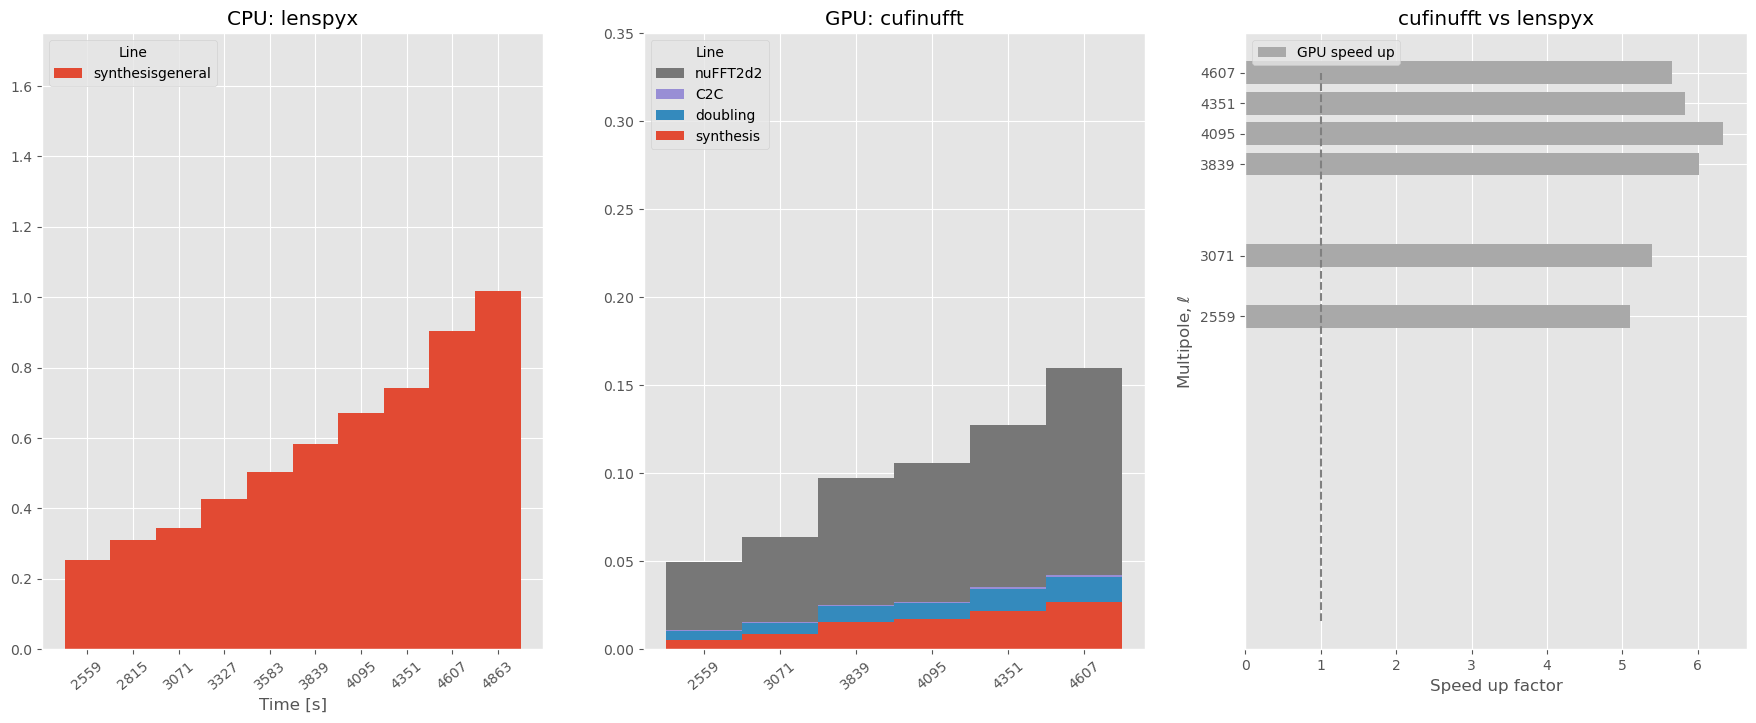

In [25]:
fig, ax = plt.subplots(1,len(runinfos)+1,figsize=(22,8), sharey=False)
for resi, res in enumerate(ress):
    bottom = np.zeros(shape=(len(lmax_ress[resi])))
    keys = data[resi][0].keys()
    for rowi, row in enumerate(res): #[:-1,:]
        # if rowi == 0:
            # ax[0].bar(lmaxs.astype(str), [0,0], 1, align='center', bottom=bottom, label='_')
        ax[resi].bar(lmax_ress[resi].astype(str), row, 1, align='center', bottom=bottom, label=list(keys)[rowi])
        bottom += row
    ax[resi].legend()
    ax[resi].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
    
    handles, labels = ax[resi].get_legend_handles_labels()
    ax[resi].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
ax[0].set_ylim(0.0, 1.75)
ax[1].set_ylim(0.0, .35)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')
    
        
axt.legend(ncol=4)
axt.vlines(0,0,len(lmax_intersecs), color='black', lw=2)
axt.set_title("synthesis_general(): {} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[0].set_xlabel('Time [s]')
axt.set_ylabel(r'Multipole $\ell$')


compis = [0,1]
lmax_unions = []
width = np.diff(lmax_ress[compis[0]])[0]//4
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        [np.sum(ress[compis[0]],axis=0)], [np.sum(ress[compis[1]],axis=0)])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = -width + rowi/len(keys)*2*width
    offset = 0
    ax[2].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 3*width/len(keys), align='center', label="GPU speed up", color='darkgrey')
    # bottom += row1[mask12]/row2[mask21]
ax[2].vlines(1,0,np.max(lmax_intersecs), color='grey', ls='--')
ax[2].legend()
ax[2].set_ylabel(r"Multipole, $\ell$")
ax[2].set_xlabel("Speed up factor")
ax[2].set_title("{} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[2].set_yticks(lmax_intersecs)
ax[2].set_yticklabels(lmax_intersecs)
# ax[resi].set_ylim(0.0, 1.5)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles[::-1], labels[::-1], loc='upper left')

# Accuracy vs time

In [147]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.style
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.style.use('ggplot')
print(mpl.style.available)

epsilons = [1e-6, 1e-10]
lmaxs = np.array([256*n-1 for n in np.arange(1,25)])
blacklist_CPU, blacklist_GPU = [], []

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

runinfos = [
    # ('CPU', 'lenspyx'),
    ('CPU', 'duccnufft'),
    ('GPU', 'cufinufft')    
    ]

blacklist_runinfos = []

popstr_runinfos = [
    ["setup", "gclm2lenmap"],
    ["nuFFT init", "FFTshift"],
    ["Transfers ->", "Transfer <-"],
    ["dlm2pointing", "spin-1 maps", "pointing"],
    ["rotation", "rotate"]
]
popstr = flatten_extend(popstr_runinfos)
fns = '/mnt/home/sbelkner/git/cunushtht/test/benchmark/timings/{backend}_{solver}_{lmax}_e{epsilon}'

for epsiloni, epsilon in enumerate(epsilons):
    for runinfoi, runinfo in enumerate(runinfos):
        _ = []
        for lmax in lmaxs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon)
            if not os.path.isfile(fn):
                _.append(lmax)
        blacklist_runinfos.append(_)

data = []
for epsiloni, epsilon in enumerate(epsilons):
    __ = []
    for runinfoi, runinfo in enumerate(runinfos):
        _ = []
        for lmax in lmaxs:
            if lmax not in blacklist_runinfos[runinfoi]:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], epsilon=epsilon, lmax=lmax)
                with open(fn, "r") as file:
                    _.append(json.load(file))
        __.append(_)
    data.append(__)

for epsiloni, epsilon in enumerate(epsilons):
    for runinfoi, runinfo in enumerate(runinfos):
        for popstring in popstr:
            for d in data[epsiloni][runinfoi]:
                if popstring in d:
                    d.pop(popstring)
              
ress = []
keys = []
for epsiloni, epsilon in enumerate(epsilons):
    __ = []
    for runinfoi, runinfo in enumerate(runinfos):
        data_across_l = {}
        for d in data[epsiloni][runinfoi]:
            keys = d.keys()
            for keyi, key in enumerate(keys):
                if key in data_across_l:
                    data_across_l[key].append(d[key])
                else:
                    data_across_l[key] = [d[key]]
        _ = np.array([v for k, v in data_across_l.items()])
        __.append(_)
    ress.append(__)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [148]:
lmax_ress = []
for blacklist_runinfoi, blacklist_runinfo in enumerate(blacklist_runinfos):
    lmax_ress.append(np.array([l for l in lmaxs if l not in blacklist_runinfo]))
print(len(lmax_ress[1]))

0


IndexError: list index out of range

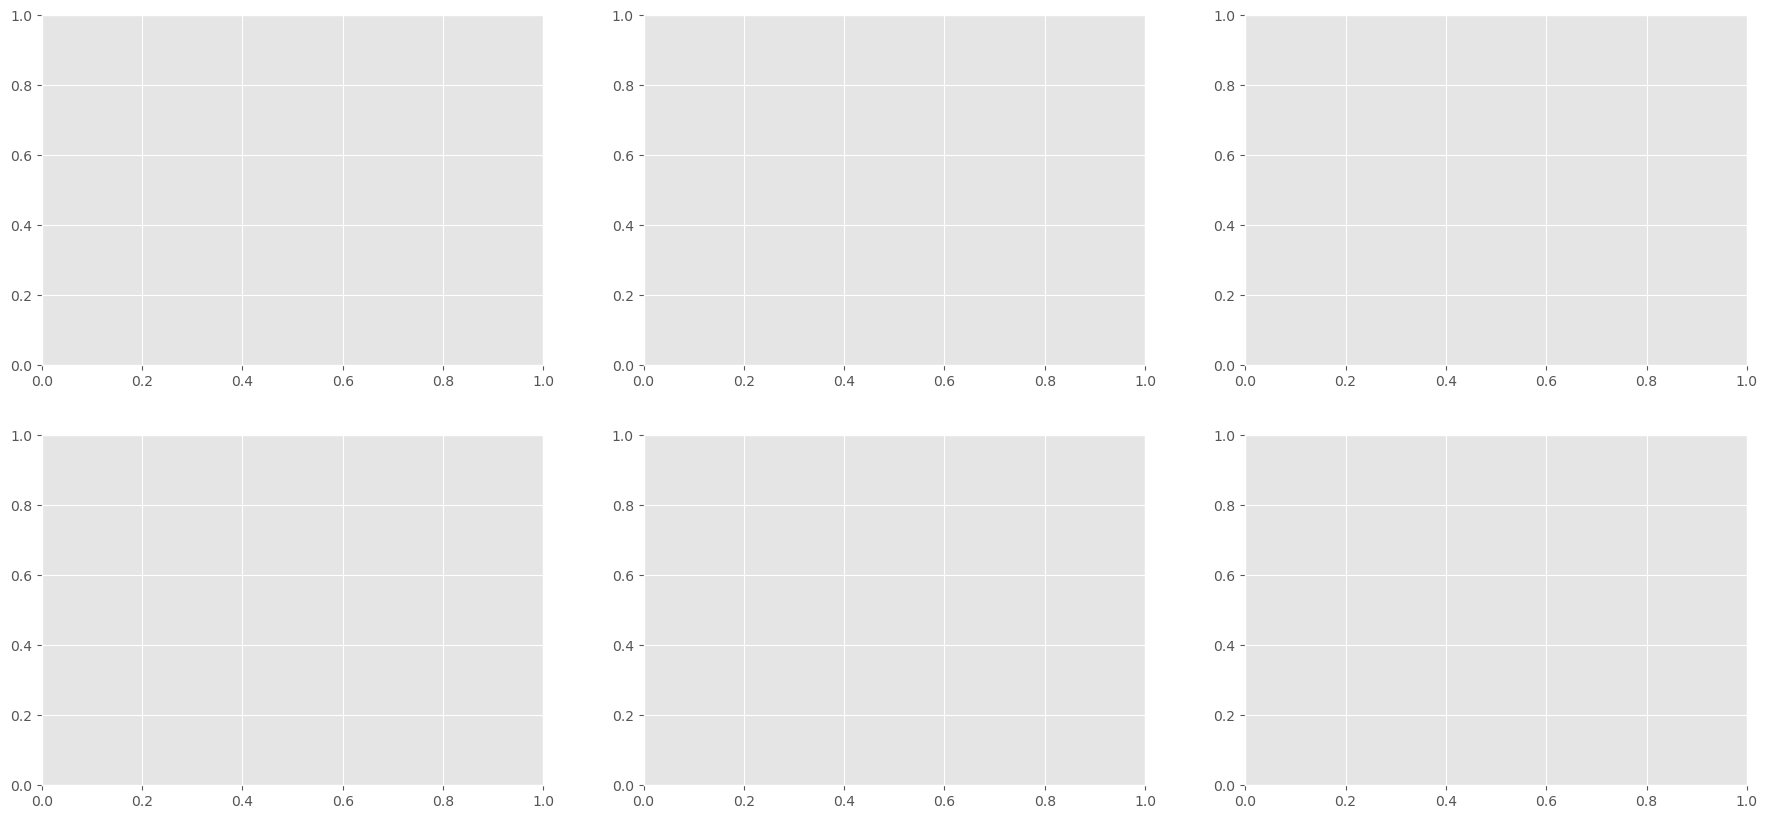

In [149]:
fig, ax = plt.subplots(len(epsilons),len(runinfos)+1,figsize=(22,10), sharey=False)
for epsiloni, epsilon in enumerate(epsilons):
    for resi, res in enumerate(ress[epsiloni]):
        bottom = np.zeros(shape=(len(lmax_ress[resi])))
        keys = data[epsiloni][resi][0].keys()
        for rowi, row in enumerate(res):
            ax[epsiloni,resi].bar(lmax_ress[resi].astype(str), row, 1, align='center', bottom=bottom, label=list(keys)[rowi])
            bottom += row
        ax[epsiloni,resi].legend()
        ax[epsiloni,resi].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
        
        handles, labels = ax[epsiloni,resi].get_legend_handles_labels()
        ax[epsiloni,resi].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
    ax[epsiloni,0].set_ylim(0.0, 11.0)
    ax[epsiloni,1].set_ylim(0.0, 0.6)
    ax[epsiloni,0].set_xticklabels(ax[epsiloni,0].get_xticklabels(), rotation=35, ha='right')
    ax[epsiloni,1].set_xticklabels(ax[epsiloni,1].get_xticklabels(), rotation=35, ha='right')

compis = [0,1]
lmax_unions = []
width = np.diff(lmax_ress[compis[0]])[0]//3
lmax_intersecs = np.array(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]]))))
print(lmax_intersecs)

# bottom = np.zeros(shape=(len(lmax_intersecs)))
# keys = data[][0].keys()
# for rowi, (row1, row2) in enumerate(
#     zip(
#         ress[compis[0]], ress[compis[1]])):
#     mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
#     mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
#     offset = -width + rowi/len(keys)*2*width
#     ax[2].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 3*width/len(keys), align='center', label=list(keys)[rowi])
#     # bottom += row1[mask12]/row2[mask21]
# ax[2].legend()
# ax[2].set_title("{} vs {}".format(runinfos[1][1], runinfos[0][1]))
# # ax[resi].set_ylim(0.0, 1.5)
# handles, labels = ax[2].get_legend_handles_labels()
# ax[2].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')